![logo](https://climate.copernicus.eu/sites/default/files/2025-03/logoline_c3s.png)

# Explore `glacier_area`

**This notebook can be run on free online platforms, such as Binder, Kaggle and Colab, or they can be accessed from GitHub. The links to run this notebook in these environments are provided here, but please note they are not supported by ECMWF.**

[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/c3s-training-submodule-sat-obs-hydro-cryo/develop?labpath=glacier-area.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-hydro-cryo/blob/develop/glacier-area.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/c3s-training-submodule-sat-obs-hydro-cryo/blob/develop/glacier-area.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-hydro-cryo/blob/develop/glacier-area.ipynb)

## Learning objectives 🎯

## Prepare your environment

### Set up CDSAPI and your credentials

The code below will ensure that the `cdsapi` package is installed. If you have not setup your `~/.cdsapirc` file with your credenials, you can replace `None` with your credentials that can be found on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [1]:
!pip install -q cdsapi
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = None

## (Install and) Import libraries

In [4]:
# Import standard libraries
import zipfile

# # Import third party libraries
import os
import cartopy.crs
import cdsapi
import matplotlib.pyplot
import numpy as np
import xarray

# Ignore distracting warnings
import warnings
warnings.filterwarnings('ignore')

### Specify data directory

Below we define a directory to store the files locally, and create this directory if it does not already exist

In [5]:
# Directory to store data
# Please ensure that data_dir is a location where you have write permissions
DATADIR = './data_dir/'
# Create this directory if it doesn't exist
os.makedirs(DATADIR, exist_ok=True)

## Explore data

We will use the [Climate Data Store (CDS) API](https://cds.climate.copernicus.eu/api-how-to) to download the [glacier extent](https://cds.climate.copernicus.eu/cdsapp#!/dataset/insitu-glaciers-extent) dataset from the Randolph Glacier Inventory for the year 2000.

### Search for the data

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in.

These parameters can all be selected in the **"Download data"** tab. In this tab, a form appears in which we will select the following parameters to download:

:::{dropdown} Parameters of data to download

The data selection in this notebook is for IASI on Metop-C:

- Variable: `Glacier area`
- Product type: `Gridded`
- Version: `RGI 6.0`

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below). Having copied the API request into the cell below, running this will retrieve and download the data you requested into your local directory.

:::{warning}

Please remember to accept the terms and conditions of the dataset, at the bottom of the CDS download form!

:::

### Download the data

With the API request copied into the cells below, running these cells will retrieve and download the data you requested into your local directory.

In [7]:
c = cdsapi.Client()
c.retrieve(
    name='insitu-glaciers-extent',
    request={
        'variable': 'glacier_area',
        'version': 'rgi_6_0',
        'format': 'zip',
        'product_type': 'gridded',
    },
    target='glacier_area-gridded.zip'
)

2025-09-17 11:06:47,123 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-17 11:06:47,123 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-09-17 11:06:47,388 INFO Request ID is 50d2e55c-a488-452c-a965-2d7e483cd786
2025-09-17 11:06:47,479 INFO status has been updated to accepted
2025-09-17 11:07:21,505 INFO status has been updated to successful


ba8391ec4753c6e8e5303e3ba9d5612c.zip:   0%|          | 0.00/265k [00:00<?, ?B/s]

'glacier_area-gridded.zip'

Since the data is downloaded as a zip file, we have to first unzip it.

In [8]:
with zipfile.ZipFile('glacier_area-gridded.zip', 'r') as file:
    file.extractall('glacier_area')

## Read and inspect data

The data are formatted as a single netCDF4 file, which can be read using [`xarray`](https://docs.xarray.dev).

In [9]:
ds = xarray.open_dataset('glacier_area/rgi6_gridded.nc')
ds

<xarray.Dataset> Size: 249kB
Dimensions:       (lon: 360, lat: 170)
Coordinates:
  * lon           (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat           (lat) float64 1kB 84.5 83.5 82.5 81.5 ... -82.5 -83.5 -84.5
Data variables:
    Glacier_area  (lat, lon) float32 245kB ...
Attributes: (12/15)
    Source_Software:            Esri ArcGIS
    NCO:                        netCDF Operators version 4.9.1 (Homepage = ht...
    title:                      Randolph Glacier Inventory v6 (RGI6) gridded ...
    project:                    Copernicus Climate Change Service (C3S) Essen...
    data_version:               version 6.0
    institution:                Department of Geography - University of Zuric...
    ...                         ...
    geospatial_lon_resolution:  1.0
    geospatial_lat_resolution:  1.0
    references:                 Pfeffer et al. (2014) doi.org/10.3189/2014JoG...
    citation:                   RGI Consortium (2017): Randolph Glacier Inven...
    Conventions:                CF Version CF-1.0
    comment:                    Brief data description: Temporal resolution: ...

Glacier area is expressed as the percent area (0–100) of each 1° x 1° grid cell, so we will need the total area of each grid cell. We can estimate this using the following spherical formula:

$(\sin(\max \mathrm{latitude}) - \sin(\min \mathrm{latitude})) * (\max \mathrm{longitude} - \min \mathrm{longitude}) * R_e^2$

where $R_e$ is the Earth's [authalic radius](https://en.wikipedia.org/wiki/Earth_radius#Authalic_radius) (6371.0072 km) and the mininum and maximum latitude and longitude of the cell are in radians.

In [10]:
CELL_SIZE = 1  # degrees
AUTHALIC_EARTH_RADIUS = 6371.0072  # kilometers
# Build grids of the longitude and latitude of (the center of) each grid cell
longitude, latitude = np.meshgrid(ds['lon'], ds['lat'])
# Compute the area of each grid cell
cell_area = (
  np.sin(np.radians(latitude + CELL_SIZE / 2)) -
  np.sin(np.radians(latitude - CELL_SIZE / 2))
) * (
  np.radians(longitude + CELL_SIZE / 2) -
  np.radians(longitude - CELL_SIZE / 2)
) * AUTHALIC_EARTH_RADIUS ** 2
ds['cell_area'] = (('lat', 'lon'), cell_area)

The cell area varies with latitude, from a minimum of 1 185 km² near the poles to a maximum of 12 364 km² at the equator.

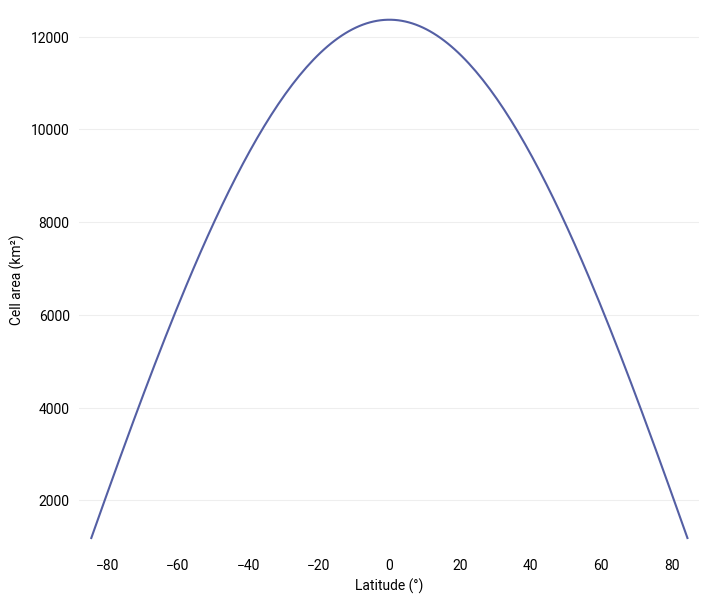

In [11]:
matplotlib.pyplot.plot(ds['lat'], ds['cell_area'][:, 0])
matplotlib.pyplot.xlabel('Latitude (°)')
matplotlib.pyplot.ylabel('Cell area (km²)')
matplotlib.pyplot.show()

Finally, we can calculate the glacier area in each grid cell (`glacier_area`) by multiplying the provided percent area (`Glacier_area`) by the total area of the grid cell calculated above (`cell_area`).

In [12]:
ds['glacier_area'] = (1 / 100) * ds['Glacier_area'] * ds['cell_area']

## Compute global glacier area

Global glacier area (in km²) can be calculated by summing the glacier area of all cells (719 117 km²).

In [13]:
ds['glacier_area'].sum().data

array(719117.00710899)

We can also count the number of 1° x 1° grid cells that contain glaciers (2105).

In [14]:
ds['glacier_area'].notnull().sum().data

array(2105)

## Plot glacier area percent on a map

We use [`matplotlib`](https://matplotlib.org/) and [`cartopy`](https://scitools.org.uk/cartopy/docs/latest) to make a global map of glacier percent area.

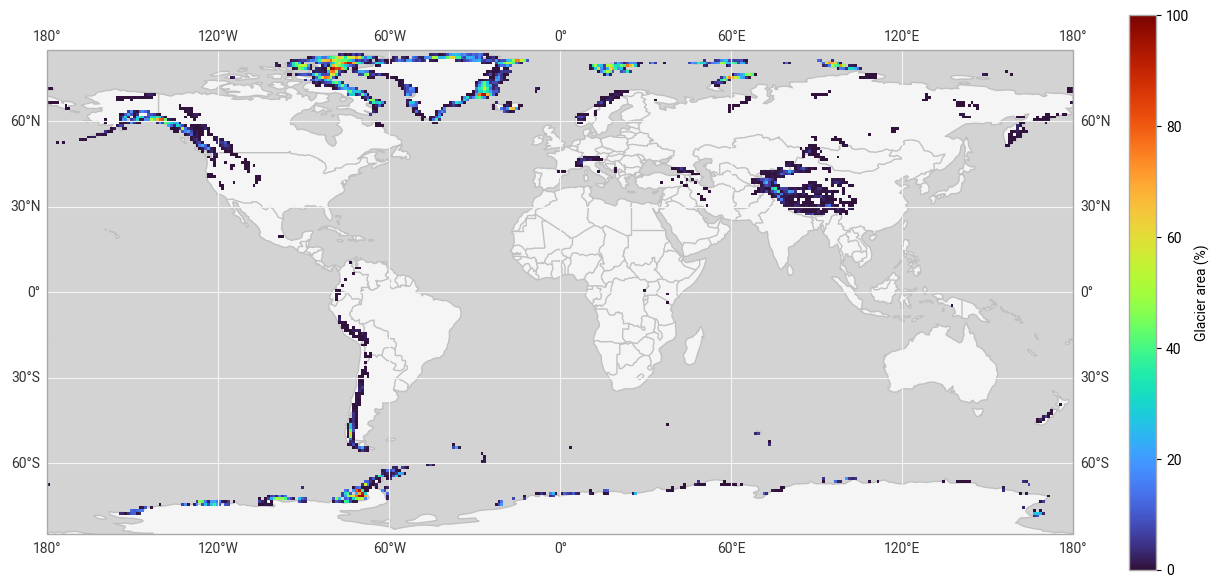

In [15]:
# Create a map with a plate carrée projection
figure = matplotlib.pyplot.figure(figsize=(12, 6))
axis = matplotlib.pyplot.axes(projection=cartopy.crs.PlateCarree())
axis.set_facecolor('lightgray')

# Add latitude, longitude gridlines
axis.gridlines(draw_labels=True, linestyle='-', color='whitesmoke', zorder=0)

# Add continents and country borders
axis.add_feature(cartopy.feature.LAND, edgecolor='silver', facecolor='whitesmoke', zorder=1)
axis.add_feature(cartopy.feature.BORDERS, edgecolor='silver', zorder=1)

# Plot glacier area
im = matplotlib.pyplot.pcolormesh(
  ds['lon'],
  ds['lat'],
  ds['Glacier_area'],
  cmap='turbo',
  vmin=0,
  vmax=100,
)

# Add a colorbar
cbar = matplotlib.pyplot.colorbar(im, fraction=0.025, label='Glacier area (%)')

# Show plot
figure.tight_layout(pad=0)
matplotlib.pyplot.show()

## Take home messages 📌